In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
letters_shapes = [
         ['111111',
          '001100',
          '001100',
          '001100',
          '001100',
          '001100'],
         ['100001',
          '010010',
          '001100',
          '001100',
          '010010',
          '100001'],
         ['001100',
          '010010',
          '100001',
          '100001',
          '010010',
          '001100'],
         ['111111',
          '100001',
          '100001',
          '100001',
          '100001',
          '111111'],
         ['001100',
          '001100',
          '110011',
          '110011',
          '001100',
          '001100']]

In [3]:
shapes = []
for l in letters_shapes:
    l_list = []
    for str_l in l:
        str_list = list(map(int, list(str_l)))
        l_list += str_list
    shapes += [l_list]

shapes = np.array(shapes)
print(shapes.shape)

(5, 36)


In [4]:
def plot_images(images):
    shape = int(np.sqrt(images.shape[1]))
    fig, ax1 = plt.subplots(1, len(images), figsize=(3, 3), sharex = True, sharey = True)
    for num, im in enumerate(images):
        ax1[num].imshow(im.reshape((shape, shape)), cmap = 'gray')
    
    plt.show()

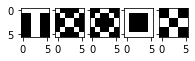

In [5]:
plot_images(shapes)

In [6]:
def make_noise(images, noise_percent):
    size = images.shape[1]
    a = np.arange(size)
    images_new = []
    for image in images:
        np.random.shuffle(a)
        randoms = a[:int(size*noise_percent/100)]
        image = np.array([not(i) if pos in randoms else i for pos, i in enumerate(image)])
        images_new += [image]
    return np.array(images_new)

In [7]:
class Activation(object):

    """
    Interface for activation functions (non-linearities).
    In all implementations, the state attribute must contain the result, i.e. the output of forward (it will be tested).
    """

    def __init__(self):
        self.state = None
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        raise NotImplementedError
    def derivative(self):
        raise NotImplementedError


class Sigmoid(Activation):

    """
    Sigmoid non-linearity
    """

    def __init__(self):
        super(Sigmoid, self).__init__()
    def forward(self, x):
        self.X = x
        self.state_x = 1 / (1 + np.exp(-x))
        return self.state_x
    def derivative(self):
        return self.state_x * (1 - self.state_x)

class ReLU(Activation):

    """
    ReLU non-linearity
    """

    def __init__(self):
        super(ReLU, self).__init__()
    def forward(self, x):
        self.X = x
        self.state_x = np.maximum(0, x)
        return self.state_x
    def derivative(self):
        return np.where(self.X <= 0, 0., 1.)

class Entropy():
    def __init__(self):
        self.logits = None
        self.labels = None
        self.e = None 
        
    def __call__(self, x, y):
        return self.forward(x, y)       
        
    def forward(self, x, y):
        self.logits = x
        self.labels = y
       
        self.e = np.sum((self.labels - self.logits)**2)/2
        return self.e
    
    def derivative(self):
        return self.labels - self.logits

In [22]:
class MLP(object):

    """
    A simple multilayer perceptron
    """

    def __init__(self, input_size, output_size, hidden_size, activations, weight_init_fn, bias_init_fn, criterion, lr):

        self.train_mode = True
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activations = activations
        self.criterion = criterion
        self.lr = lr
        # <---------------------

        self.W1 = weight_init_fn(self.input_size, self.hidden_size)
        self.dW1 = np.zeros_like(self.W1)
        self.b1 = bias_init_fn(self.hidden_size)
        self.db1 = np.zeros_like(self.b1)
        
        self.W2 = weight_init_fn(self.hidden_size, self.output_size)
        self.dW2 = np.zeros_like(self.W2)
        self.b2 = bias_init_fn(self.output_size)
        self.db2 = np.zeros_like(self.b2)

        self.layer1_input = None
        #self.layer1_output = None
        self.layer2_input = None
        #self.layer2_output = None
        self.prediction = None
        self.loss = None

    def forward(self, x):
        self.layer1_input = x
        z = np.dot(self.layer1_input, self.W1) + self.b1
        y = self.activations[0](z)
        #self.layer1_output = z
        self.layer2_input = y
        
        z = np.dot(self.layer2_input, self.W2) + self.b2
        y = self.activations[1](z)
        #self.layer2_output = z
        self.prediction = y

        return y        

    def step(self):
        
        if self.train_mode:
            # update weights
            self.W1 += self.lr * self.dW1
            self.W2 += self.lr * self.dW2
            # update biases
            self.b1 += self.lr * self.db1
            self.b2 += self.lr * self.db2

    def backward(self, label):

        # calculate criterion to get divergence (diff with actual labels)
        self.loss = self.criterion(self.prediction, label)
        div = self.criterion.derivative()
        
        dz = self.activations[1].derivative() * div
        self.dW2 = np.outer([self.layer2_input], dz)
        self.db2 = dz
        div = np.dot(dz, self.dW2.T)
        
        dz = self.activations[0].derivative() * div
        self.dW1 = np.outer([self.layer1_input], dz)
        self.db1 = dz
        
        return div

    def __call__(self, x):
        return self.forward(x)

    def train(self):
        self.train_mode = True

    def evaluate(self):
        self.train_mode = False


In [9]:
def random_normal_weight_init(d0, d1):
    return np.random.randn(d0, d1)

def zeros_bias_init(d):
    return np.zeros((1, d))

In [10]:
def get_test_stats(mlp, test_x, test_y):
    mlp.evaluate()
    objects_num = len(np.unique(test_y))
    test_y_onehot = np.eye(objects_num)[test_y]
    errores = loses = 0
    for txb in range(len(test_y)):
        score = mlp.forward(test_x[txb])
        mlp.backward(test_y_onehot[txb])
        errores += test_y[txb] != np.argmax(score)
        loses += mlp.loss

    test_loss = loses / len(test_y)
    test_error = errores / len(test_y)
    return (test_loss, test_error)

In [11]:
def get_training_stats(mlp, train_dset, val_dset, nepochs):

    trainx, trainy = train_dset
    valx, valy = val_dset
    objects_num = len(np.unique(trainy))
    objects_ls = np.arange(len(trainx))

    best_validation_loss = 2
    best_validation_error = 1
    best_epoch = 0
    best_weights = [mlp.W1, mlp.W2]
    best_biases = [mlp.b1, mlp.b2]
    
    training_losses = []
    training_errors = []
    validation_similarities = []
    validation_losses = []
    validation_errors = []

    # Setup ...
    for e in range(nepochs):

        # Per epoch setup ...
        training_loss = validation_loss = 0
        training_error = validation_error = 0
        training_loss = loses = 0
        training_error = errores = 0
        
        np.random.shuffle(objects_ls)
        trainx, trainy = trainx[objects_ls], trainy[objects_ls]
        
        mlp.train()
        for txb in range(len(trainx)):

            train_x, train_y = trainx[txb], trainy[txb]
            train_y_onehot = np.eye(objects_num)[train_y]

            score = mlp.forward(train_x)
            mlp.backward(train_y_onehot)

            training_loss += mlp.loss
            training_error += train_y != np.argmax(score)

            # SGD
            mlp.step()

        training_losses.append(training_loss / len(trainx))
        training_errors.append(training_error / len(trainx))

        # Validate
        mlp.evaluate()

        val_y_onehot = np.eye(objects_num)[valy]
        for vxb in range(len(valy)):
            score = mlp.forward(valx[vxb])
            mlp.backward(val_y_onehot[vxb])
            errores += valy[vxb] != np.argmax(score)
            loses += mlp.loss

        validation_loss = loses / len(valy)
        validation_error = errores / len(valy)
        if (validation_error<best_validation_error) & (validation_loss<best_validation_loss):
            best_validation_error = validation_error
            best_validation_loss = validation_loss
            best_epoch = e
            best_weights = [mlp.W1, mlp.W2]
            best_biases = [mlp.b1, mlp.b2]

        validation_losses.append(validation_loss)
        validation_errors.append(validation_error)

    return (training_losses, training_errors, validation_similarities, validation_losses, validation_errors, \
            best_validation_error, best_validation_loss, best_epoch, best_weights, best_biases)


In [62]:
mlp = MLP(input_size = shapes.shape[1], \
          output_size = shapes.shape[0], \
          hidden_size = 45, \
          activations = [Sigmoid(), Sigmoid()], \
          weight_init_fn = random_normal_weight_init, \
          bias_init_fn = zeros_bias_init, \
          criterion = Entropy(), \
          lr=0.6)

In [63]:
n_epochs = 20
train_size = 5
train_shapes = make_noise(np.repeat(shapes, train_size, axis=0), 3) #one bit
train_answers = np.repeat([i for i in range(shapes.shape[0])], train_size)
train_shapes = [train_shapes, train_answers]
val_size = 3
val_shapes = make_noise(np.repeat(shapes, val_size, axis=0), 6)
val_answers = np.repeat([i for i in range(shapes.shape[0])], val_size)
val_shapes = [val_shapes, val_answers]
train_loss, train_err, val_sim, val_loss, val_err, best_err, best_loss, best_epoch, best_weights, best_biases = get_training_stats(mlp, train_shapes, val_shapes, n_epochs)

The best error  0.0
The best loss  0.10126976355854375
The best epoch  10


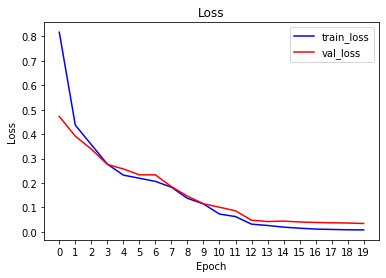

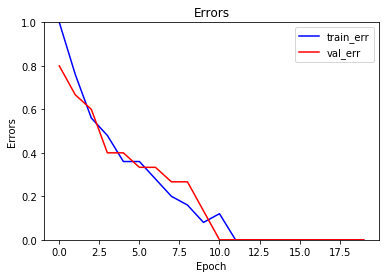

In [64]:
print("The best error ", best_err)
print("The best loss ", best_loss)
print("The best epoch ", best_epoch)
epochs = [i for i in range(n_epochs)]
plt.plot(epochs, train_loss, c = 'b', label = 'train_loss')
plt.plot(epochs, val_loss, c = 'r', label = 'val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.xticks(epochs)
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, train_err, c = 'b', label = 'train_err')
ax.plot(epochs, val_err, c = 'r', label = 'val_err')
ax.set_title('Errors')
ax.set_xlabel('Epoch')
ax.set_ylabel('Errors')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
plt.show()

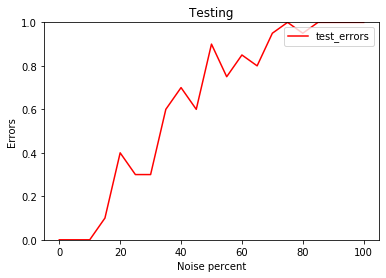

In [65]:
test_size = 4 
mlp.W1, mlp.W2 = best_weights
mlp.b1, mlp.b2 = best_biases
noise_percent = np.linspace(0, 100, num=21, dtype = int)
test_shapes = np.repeat(shapes, test_size, axis=0)
test_answers = np.repeat([i for i in range(shapes.shape[0])], test_size) 

test_losses = []
test_errors = []
for noise in noise_percent:
    noise_test_shapes = make_noise(test_shapes, noise)
    test_loss, test_error = get_test_stats(mlp, noise_test_shapes, test_answers)
    test_losses.append([test_loss])
    test_errors.append([test_error])

fig, ax = plt.subplots()
#plt.plot(noise_percent, test_losses, c = 'b', label = 'test_losses')
ax.plot(noise_percent, test_errors, c = 'r', label = 'test_errors')
ax.set_title('Testing')
ax.set_xlabel('Noise percent')
ax.set_ylabel('Errors')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
plt.show()